In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import numpy as np
from pathlib import Path 

from pytorch_fid.inception import InceptionV3

from soul_gan.utils.general_utils import IgnoreLabelDataset

from soul_gan.utils.metrics.compute_fid import get_activation_statistics

In [3]:
batch_size = 100
dims = 2048

device = torch.device(0)

In [4]:
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

model = InceptionV3([block_idx]).to(device)
model.eval()
print()

In [18]:
dataset = torchvision.datasets.CIFAR10('../data/cifar10', train=True, transform=torchvision.transforms.ToTensor())
dataset = IgnoreLabelDataset(dataset)

In [19]:
len(dataset)

50000

In [20]:
mu, sigma, _ = get_activation_statistics(dataset, model, dims=2048, batch_size=100, num_workers=4, device=device)

In [21]:
np.savez(Path('../stats/fid_stats_cifar10.npz'), mu=mu, sigma=sigma)

In [22]:
mu

array([0.09976813, 0.24318884, 0.2982641 , ..., 0.50716566, 0.39214507,
       0.64979509])

In [10]:
np.load(Path('../stats/fid_stats_cifar10.npz'))['mu']

array([0.09976813, 0.24318884, 0.2982641 , ..., 0.50716566, 0.39214507,
       0.64979509])

In [4]:
from soul_gan.models.utils import load_gan
from soul_gan.utils.general_utils import DotConfig
import yaml
from yaml import Loader


gan_config = '../configs/gan_configs/dcgan.yml'

gan_config = DotConfig(
    yaml.load(Path(gan_config).open("r"), Loader)
)
gen, _ = load_gan(gan_config, device)

In [6]:
from soul_gan.utils.metrics.compute_fid import calculate_frechet_distance

In [7]:
stats = np.load(Path('../stats/fid_stats_cifar10.npz'))
real_mu, real_sigma = stats['mu'], stats['sigma']

In [10]:
fids = []
ns = np.array([5000]) #100, 250, 500, 1000, 5000])
for n in ns:
    imgs = gen(torch.randn(n, gen.z_dim).to(device))
    imgs = gen.inverse_transform(imgs)

    dataset = torch.utils.data.TensorDataset(imgs.detach().cpu())
    dataset = IgnoreLabelDataset(dataset)
    mu, sigma, _ = get_activation_statistics(dataset, model, dims=2048, batch_size=50, num_workers=4, device=device)
    fid = calculate_frechet_distance(mu, sigma, real_mu, real_sigma)
    fids.append(fid)

In [11]:
fids

[37.42481709943695]

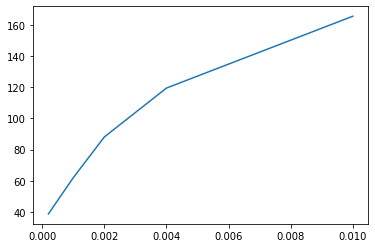

In [15]:
from matplotlib import pyplot as plt

plt.plot(1./ns, fids)
plt.show()

In [16]:
1./ns

array([0.01  , 0.004 , 0.002 , 0.001 , 0.0002])

In [4]:
torchvision.__version__

'0.11.1+cu102'

In [17]:
model = torchvision.models.efficientnet_b3(pretrained=True).to(device)
model.eval()
print()

In [18]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation['avg_pool'] = output.detach()
    return hook
model.avgpool.register_forward_hook(get_activation('avgpool'))

def wrapped_model(x):
    model(x)
    return [activation['avg_pool']]

In [22]:
activation['avg_pool'].shape

torch.Size([100, 1536, 1, 1])

In [19]:
dataset = torchvision.datasets.CIFAR10('../data/cifar10', train=True, transform=torchvision.transforms.ToTensor())
dataset = IgnoreLabelDataset(dataset)

In [23]:
mu, sigma, _ = get_activation_statistics(dataset, wrapped_model, dims=1536, batch_size=100, num_workers=4, device=device)

In [24]:
np.savez(Path('../stats/efficientnet_b3_stats_cifar10.npz'), mu=mu, sigma=sigma)